## Biostat M280 HW3
Due 05/19  

## Q1

Let $A=(a_{ij}) \in \{0,1\}^{n\times n}$ be the connectivity matrix of $n$ web pages with entries

$$
a_{ij}=\begin{cases}
1 & i\rightarrow j\\
0 & else
\end{cases}
$$

where $i \rightarrow j$ denotes an edge from page $i$ to $j$. Let $r_i = \sum_j a_{ij}$ denote the out-degree of page $i$.

Let $p$ denote the probability of randomly choosing a link $i \rightarrow j$ and $q = (1-p)$ the probability of randomly choosing one page of the set of all $n$ pages.   

Then $p_{ij}$ denotes the probability of transition $i \rightarrow j$

$$
p_{ij}=\begin{cases}
p\cdot\frac{a_{ij}}{r_i} + q\cdot\frac{1}{n} & r_i > 0\\
\frac{1}{n} & r_i = 0.
\end{cases}
$$

Let $P$ denote the transition matrixsad

$$
P = Q+R\cdot A
$$

where

$$
Q=\frac{1}{n}\cdot q\cdot1_{1\times n}
$$

with $q = (q_1,q_2,\ldots,q_n)^T \in \mathbb{R}^n$ with

$$
q_i=\begin{cases}
q, & r_i > 0\\
1, & r_i = 0
\end{cases}
$$

and

$$
R=\left(\begin{array}{cccc}
\widetilde{r}_{1} & 0 & \ldots & 0\\
0 & \widetilde{r}_{2} &  & \vdots\\
\vdots &  & \ddots & 0\\
0 & \cdots & 0 & \widetilde{r}_{n}
\end{array}\right)
$$

with

$$
\widetilde{r}_i=\begin{cases}
\frac{p}{r_i}, & r_i > 0\\
0, & r_i = 0.
\end{cases}
$$

## Q2

Let $P=(p_{ij})$ denote $\vert\Omega\vert\times\vert\Omega\vert$ transition matrix where $p_{ij} = P(x_{t+1}=j\vert x_t=i)$ with transition $i \rightarrow j$ for a Markov chain on $\Omega$ as stochastic process $\{X_0,X_1,\ldots,X_n\}$.
  
We assume $P$ is irreducable and aperiodic, that is the chain is ergodic. We observe $P$ is a non-negative row-stochastic matrix $P\cdot1=1$.
   
Then the fundamental theorem of Markov Chains states that there exists a unique stationary distribution $\pi$ as left-eigenvector such that $\pi P=\pi$ with spectral radius $\rho(P) = \max \left \{ |\lambda_1|, \cdots, |\lambda_n| \right \} = 1$. We omit the proof which is a direct consequence of the Perron-Frobenius theorem.
  
We formulate the above as left eigen-value problem $\pi P=\pi\lambda$ as $P^T\pi^T=\lambda\pi^T$ which can be equivalently stated as $(P^T-\lambda I)\pi^T = 0.$ In our case, we want to solve for $\lambda=1$ with stationary distribution $\pi$ and we obtain the linear system

$$(P^T - I)\pi^T = 0.$$

Observe $P\cdot1=1$ causes $\det(P^T-I)=0$ since the rows are not linearly independent or equivalently the sum of each column is zero. Since $\pi$ must be a probability distribution, we can further constraint the system with $\sum_i\pi_i=1$.

## Q3

In [1]:
A = readdlm("A.txt", ',');
U = readdlm("U.txt", ',');
As = sparse(A);
p = 0.85;
inedges = sum(A, 1);
outedges = sum(A, 2);

In [2]:
"#pages = " * string(size(A)[1])

"#pages = 500"

In [3]:
"#links = " * string(sum(A))

"#links = 11158.0"

In [4]:
"#dangling = " * string(sum(outedges .< 1))

"#dangling = 96"

In [5]:
U[indmax(inedges)]

"http://www.ucla.edu"

In [6]:
U[indmax(outedges)]

"http://giveto.ucla.edu"

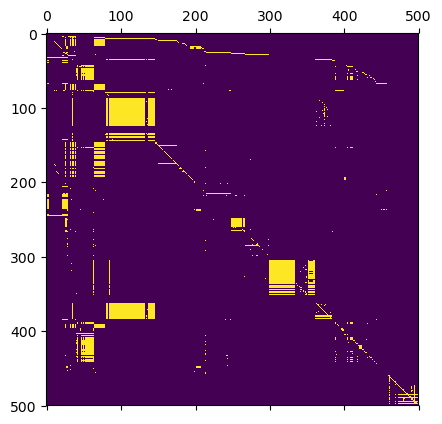

PyObject <matplotlib.image.AxesImage object at 0x7f2c69264190>

In [7]:
using PyPlot
matshow(A)

## Q4

** 1) LU **

In [7]:
function pagerank_lu(A::AbstractMatrix, telep::Float64 = 0.85)
    
    n = size(A, 1)
    # r and z vectors
    outdeginv = vec(sum(A, 2))
    z = zeros(outdeginv)
    fill!(z, 1 / n)
    for i in 1:n
        if outdeginv[i] > 0
            outdeginv[i] = telep / outdeginv[i]
            z[i] = (1 - telep) / n
        end
    end
    # P = outdeginv * A .+ z
    # prepare the linear system I - P^t
    M = I - full(A') * Diagonal(outdeginv) .- z'
    # replace the first equation by the sum-to-1 constraint
    M[1, :] = 1.0
    # LU solve with right hand side e_1
    b = zeros(n)
    b[1] = 1.0
    return M \ b
    
end

pagerank_lu (generic function with 2 methods)

In [23]:
function pr_lu(A, p)
    # matrices
    (n, n) = size(A)
    r = sum(A, 2)
    q = 1/n * [r[i] > 0 ? (1-p) : 1 for i=1:n]
    r_tilde = [r[i] > 0 ? (p / r[i]) : 0 for i=1:n]
    RA = r_tilde .* A
    P = RA .+ q
    
    # slow
    # RA = diagm(r_tilde) * A
    # Q = q * ones(1, n)
    # P = RA + Q
    
    # decomposition
    I = sparse(eye(n))
    I_P = (I - P')
    I_P[1,:] = 1
    b = [1; zeros(n - 1)]
    x = lufact(I_P) \ b
    return vec(x)
end

pr_lu (generic function with 1 method)

** 2) Jacobi **

Let $Ax=b$ be a linear system of equations. Let $A=D+R$ where $D=diag(A)$ and $R$ denotes the non-diagonal elements. Then the solution is obtained by Jacobi iterations

$$
x^{(k+1)} = D^{-1}(b - R x^{(k)}).
$$

In our case we have $A = (I-P')$, $b=0$ and $x=\pi$.

In [22]:
function pr_jacobi(A, p)
    # matrices
    (n, n) = size(A)
    r = sum(A, 2)
    q = 1/n * [r[i] > 0 ? (1 - p) : 1 for i = 1:n]
    r_tilde = [r[i] > 0 ? (p / r[i]) : 0 for i = 1:n]
    RA = r_tilde .* A
    P = RA .+ q
    
    # slow
    # RA = diagm(r_tilde) * A
    # Q = q * ones(1, n)
    # P = RA + Q
    
    # init
    #I = sparse(eye(n))
    #I_P = (I - P')
    # R = I_P - diagm(diag(I_P)) # we lose sparisty here, slow
    x = ones(n ,1) ./ n
    #D = diag(I_P)
    D = 1 - diag(P')
    
    # jacobi
    for i = 1:100
        x_prev = x
        
        # derivation to increase efficiency
        # x = ( -R*x ) ./ D
        # x = ( -((I - P')  - diagm(diag(I_P)))*x ) ./ D
        # x = ( -((I - P')  - diagm(D))*x ) ./ D
        # x = ( -(I - P')*x + diagm(D)*x ) ./ D
        # x = -Ix ./ D + P'x ./ D + diagm(D)*x ./ D
        # x = -x ./ D + (P'*x) ./ D + x  
        
        # reduce memory allocation by avoiding (P = RA .+ q)
        x = -x ./ D + (RA' * x) ./ D + (q' * x) ./ D + x 
        l1 = sum(abs(x_prev - x))
        
        #if i % 10 == 0
        #    println(string(l1))
        #end
        
        if(l1 < 1e-7)
            break
        end
    end
    x = abs(x / sum(x))
    
    return vec(x)
end

pr_jacobi (generic function with 1 method)

**3) Dense eigen-solver**

In [25]:
function pr_dense_eig(A, p)
    # matrices
    (n, n) = size(A)
    r = sum(A, 2)
    q = 1 / n * [r[i] > 0 ? (1 - p) : 1 for i = 1:n]
    r_tilde = [r[i] > 0 ? (p / r[i]) : 0 for i = 1:n]
    RA = r_tilde .* A
    P = RA .+ q
    
    # solve
    (eig_d, eig_v) = eig(P')
    x = real(eig_v[:, indmax(real(eig_d))])
    x = abs(x / sum(x))
    
    return vec(x)
end

pr_dense_eig (generic function with 1 method)

**4) Power method**

In [26]:
function pr_power(A, p)
    # matrices
    (n, n) = size(A)
    r = sum(A, 2)
    q = 1 / n * [r[i] > 0 ? (1 - p) : 1 for i = 1:n]
    r_tilde = [r[i] > 0 ? (p / r[i]) : 0 for i = 1:n]
    RA = r_tilde .* A
    
    # init
    x = ones(1, n) ./ n
    
    # power
    for i = 1:100
        x_prev = x
        x = x * RA + sum(x * q)
        x ./= norm(x)

        l1 = sum(abs(x_prev - x))
        #if i % 10 == 0
        #    println(string(l1))
        #end
        if(l1 < 1e-7)
            break
        end
    end
    x /= sum(x)

    return(vec(x))
end

pr_power (generic function with 1 method)

** Correctness **

In [10]:
sort(pr_lu(As, p), rev=true)[1:10]

10-element Array{Float64,1}:
 0.0196564 
 0.0185276 
 0.0171095 
 0.0153243 
 0.0133015 
 0.0121278 
 0.0115263 
 0.0104137 
 0.00977602
 0.00750605

In [23]:
sort(pr_jacobi(As, p), rev=true)[1:10]

10-element Array{Float64,1}:
 0.0196564 
 0.0185276 
 0.0171095 
 0.0153243 
 0.0133015 
 0.0121278 
 0.0115263 
 0.0104137 
 0.00977602
 0.00750605

In [85]:
sort(pr_dense_eig(As, p), rev=true)[1:10]

10-element Array{Float64,1}:
 0.0196564 
 0.0185276 
 0.0171095 
 0.0153243 
 0.0133015 
 0.0121278 
 0.0115263 
 0.0104137 
 0.00977602
 0.00750605

In [81]:
sort(pr_power(As, p), rev=true)[1:10]

10-element Array{Real,1}:
 0.0196564 
 0.0185276 
 0.0171095 
 0.0153243 
 0.0133015 
 0.0121278 
 0.0115263 
 0.0104137 
 0.00977602
 0.00750605

**Benchmark**

In [12]:
Pkg.add("BenchmarkTools")
using BenchmarkTools

INFO: Recompiling stale cache file /home/juser/.julia/lib/v0.5/JLD.ji for module JLD.


In [28]:
@benchmark pr_lu(As, p)

BenchmarkTools.Trial: 
  memory estimate:  35.16 MiB
  allocs estimate:  1538657
  --------------
  minimum time:     2.557 s (0.78% GC)
  median time:      2.599 s (1.25% GC)
  mean time:        2.599 s (1.25% GC)
  maximum time:     2.640 s (1.70% GC)
  --------------
  samples:          2
  evals/sample:     1

In [13]:
@benchmark pagerank_lu(As, p)

BenchmarkTools.Trial: 
  memory estimate:  9.74 MiB
  allocs estimate:  51
  --------------
  minimum time:     3.011 s (0.00% GC)
  median time:      3.082 s (0.00% GC)
  mean time:        3.082 s (0.00% GC)
  maximum time:     3.152 s (0.00% GC)
  --------------
  samples:          2
  evals/sample:     1

In [24]:
@benchmark pr_jacobi(As, p)

BenchmarkTools.Trial: 
  memory estimate:  35.29 MiB
  allocs estimate:  1842281
  --------------
  minimum time:     2.012 s (0.00% GC)
  median time:      2.018 s (0.00% GC)
  mean time:        2.024 s (0.00% GC)
  maximum time:     2.042 s (0.00% GC)
  --------------
  samples:          3
  evals/sample:     1

In [31]:
@benchmark pr_dense_eig(As, p)

BenchmarkTools.Trial: 
  memory estimate:  23.86 MiB
  allocs estimate:  788314
  --------------
  minimum time:     1.508 s (1.77% GC)
  median time:      1.518 s (2.19% GC)
  mean time:        1.517 s (2.12% GC)
  maximum time:     1.525 s (2.24% GC)
  --------------
  samples:          4
  evals/sample:     1

In [32]:
@benchmark pr_power(As, p)

BenchmarkTools.Trial: 
  memory estimate:  61.12 MiB
  allocs estimate:  3873544
  --------------
  minimum time:     5.925 s (0.53% GC)
  median time:      5.925 s (0.53% GC)
  mean time:        5.925 s (0.53% GC)
  maximum time:     5.925 s (0.53% GC)
  --------------
  samples:          1
  evals/sample:     1

## Q5

In [30]:
using DataFrames
p = 0.85
indegree = sum(A,1);
outdegree = sum(A,2);
x = pr_lu(As, p)
rank = sortperm(x, rev=true)[1:20]
df = DataFrame(Url = U[rank], Rank = x[rank], In = indegree[rank], Out = outdegree[rank])

,Url,Rank,In,Out
1,http://hammer.ucla.edu,0.01965638895811204,8.0,1.0
2,http://schema.org,0.01852764462659933,43.0,0.0
3,http://www,0.017109545571273588,126.0,0.0
4,http://giveto.ucla.edu/comments/feed,0.015324325326110787,72.0,1.0
5,http://browsehappy.com,0.013301527426548875,6.0,1.0
6,http://schema.org/Text,0.012127809973258121,28.0,2.0
7,http://www.ucla.edu,0.01152628491759765,171.0,28.0
8,http://www.directory.ucla.edu,0.010413659925872554,112.0,40.0
9,http://www.universityofcalifornia.edu,0.009776022768490595,53.0,35.0
10,http://schema.org/CreativeWork,0.007506052472695943,27.0,30.0


## Q6

1. LU: Unlikely.
2. Jacobi: Likely.
3. Dense eigen-solver: Unlikely.
4. Power: Likely.

We assume iterative approaches such as a Jacobi or Power method (or variations) could be able to solve the eigen-value problem at this scale. Further, iterative algorithms allow us to early exit with an approximate result which should be sufficient for the pagerank problem. Since we are only intersted in the eigenvector corresponding to the largest eigenvalue, that is the stationary distribution (see Perron–Frobenius theorem), the power method appears particularly applicable.  

In contrast, exact methods like the LU and dense eigen solvers might require large amounts of memory. Sparse matrices in general do not have a sparse LU decomposition, and if the factors do not fit into (fast) memory, these methods become unusable. However, there appears to be research regarding sparse LU decomposition of Markov kernels.